In [1]:
from scoring import extract_pb_notes

with open("../scores/spider dance oemer.pb", "rb") as f:
    notes_oemer = extract_pb_notes(f.read()).notes
with open("../scores/spider dance transkun.pb", "rb") as f:
    notes_transkun = extract_pb_notes(f.read()).notes
notes_transkun = list(filter(lambda note: note.pitch > 0, notes_transkun))

In [2]:
from time import time
import numpy as np
from numba import njit, int32, int8, float32


@njit
def _align_numba(
    p1: np.ndarray,
    t1: np.ndarray,
    p2: np.ndarray,
    clef_offset: int32,
    pitch_tolerance: int32,
    max_cost: int32,
):
    m, n = p1.shape[0], p2.shape[0]

    # 1) Clef transpose
    trans1 = np.empty(m, dtype=int32)
    for i in range(m):
        if t1[i] == 0:
            trans1[i] = p1[i] - clef_offset
        elif t1[i] == 1:
            trans1[i] = p1[i] + clef_offset
        else:
            trans1[i] = p1[i]

    # 2) Precompute cost matrix
    cost = np.empty((m, n), dtype=float32)
    denom = max_cost - pitch_tolerance
    for i in range(m):
        pi = p1[i]
        ti = trans1[i]
        for j in range(n):
            pj = p2[j]
            # compute best of four diffs
            d0 = abs(pi - pj)
            d1 = abs(pj - ti)
            best = d0
            if d1 < best:
                best = d1
            # map to [0,1]
            d = (best - pitch_tolerance) / denom
            if d < 0.0:
                cost[i, j] = 0.0
            elif d > 1.0:
                cost[i, j] = 1.0
            else:
                cost[i, j] = d

    DIAG, DEL, INS, SWAP = 0, 1, 2, 3

    # 3) DP tables
    dp = np.zeros((m + 1, n + 1), dtype=float32)
    back = np.zeros((m + 1, n + 1), dtype=int8)
    swap_len = np.zeros((m + 1, n + 1), dtype=int32)

    dp[1 : m + 1, 0] = np.arange(1, m + 1, dtype=float32)
    dp[0, 1 : n + 1] = np.arange(1, n + 1, dtype=float32)
    back[1 : m + 1, 0] = DEL
    back[0, 1 : n + 1] = INS

    # fill
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            best = dp[i - 1, j - 1] + cost[i - 1, j - 1]
            op = DIAG

            # deletion
            tmp = dp[i - 1, j] + 1.0
            if tmp < best:
                best, op = tmp, DEL

            # insertion
            tmp = dp[i, j - 1] + 1.0
            if tmp < best:
                best, op = tmp, INS

            max_swap = 7  # swaps up to this amount away
            max_k = max_swap if max_swap < i and max_swap < j else min(i, j) - 1
            for k in range(1, max_k + 1):
                if cost[i - 1, j - k - 1] == 0.0 and cost[i - k - 1, j - 1] == 0.0:
                    ok = True
                    for x in range(k - 1):
                        if cost[i - k + x, j - k + x] != 0.0:
                            ok = False
                            break
                    if ok:
                        tmp = dp[i - k - 1, j - k - 1] + 1.0
                        if tmp < best:
                            best, op = tmp, SWAP
                            swap_len[i, j] = k
                        break

            dp[i, j] = best
            back[i, j] = op

    # backtrace
    alignment = []
    i, j = m, n
    while i > 0 or j > 0:
        op = back[i, j]
        if op == DIAG:
            alignment.append((i - 1, j - 1))
            i, j = i - 1, j - 1
        elif op == DEL:
            alignment.append((i - 1, None))
            i -= 1
        elif op == INS:
            alignment.append((None, j - 1))
            j -= 1
        else:  # SWAP
            L = swap_len[i, j]
            for x in range(L + 1):
                alignment.append((i - 1 - x, j - L - 1 + x))
            i -= L + 1
            j -= L + 1

    # reverse in-place
    for a in range(len(alignment) // 2):
        alignment[a], alignment[-1 - a] = alignment[-1 - a], alignment[a]

    return dp[m, n], alignment


def align(seq1, seq2, clef_offset=21, pitch_tolerance=2, max_cost=6):
    start_time = time()

    # extract raw arrays
    m = len(seq1)
    n = len(seq2)
    p1 = np.empty(m, dtype=np.int32)
    t1 = np.empty(m, dtype=np.int8)
    p2 = np.empty(n, dtype=np.int32)
    for i, note in enumerate(seq1):
        p1[i] = note.pitch
        t1[i] = note.track
    for j, note in enumerate(seq2):
        p2[j] = note.pitch

    print(f"Setup: {(time() - start_time) * 1e3:.1f}ms")

    # call the compiled core
    start_time = time()
    result = _align_numba(p1, t1, p2, clef_offset, pitch_tolerance, max_cost)
    print(f"DP & Backtrack: {(time() - start_time) * 1e3:.1f}ms")
    return result


# Example usage:
# (The following expects that notes_transkun and notes_oemer are defined as lists of dicts.)

# Sort the lists based on start times and pitch.
notes_transkun.sort(key=lambda note: (round(note.start_time, 1), note.pitch))
notes_oemer.sort(key=lambda note: (round(note.start_time, 1), note.pitch))

# Wrap the sequences by extracting the pitch values.
min_cost, aligned_pairs = align(notes_oemer, notes_transkun)
print("Final alignment pair:", aligned_pairs[-1])
print("Number of notes in transkun:", len(notes_transkun))
print("Number of notes in oemer:", len(notes_oemer))

print("\nMin cost:", min_cost)

Setup: 0.8ms
DP & Backtrack: 2333.7ms
Final alignment pair: (1895, 1850)
Number of notes in transkun: 1851
Number of notes in oemer: 1896

Min cost: 908.0


Match: 651 / 2039	Accuracy: 31.93%


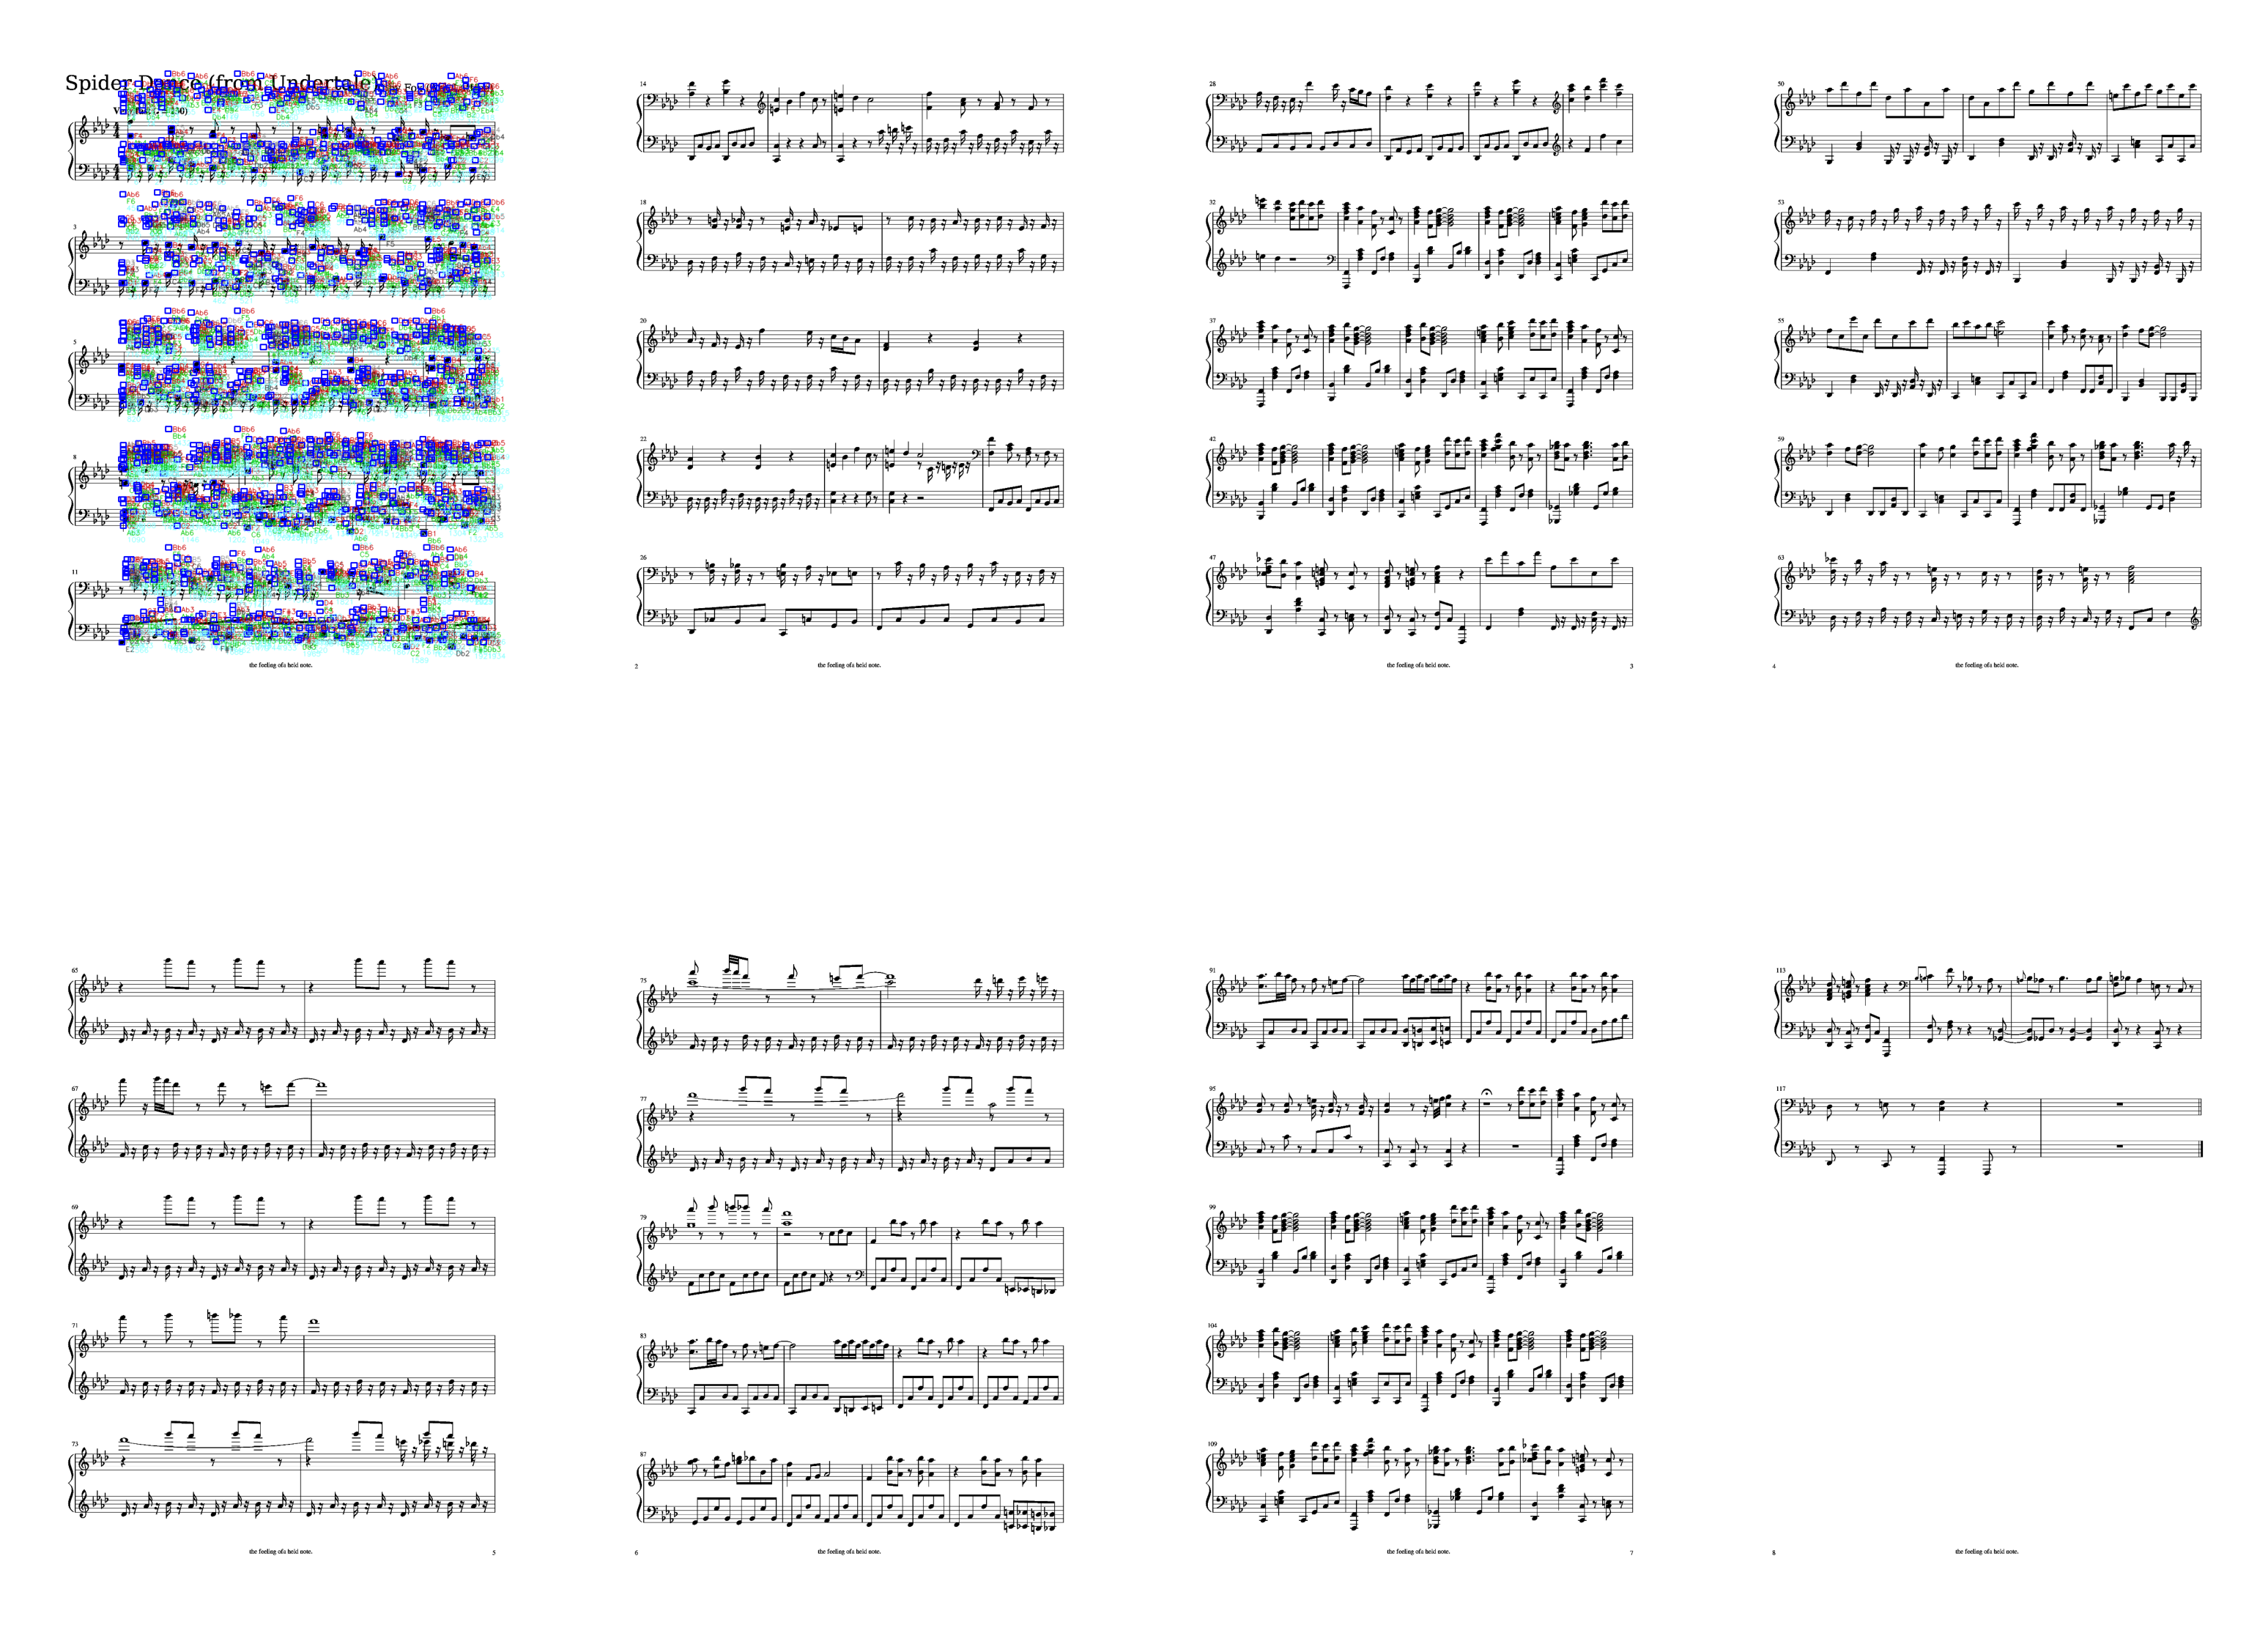

In [9]:
from matplotlib import pyplot as plt
import cv2


def putText(img, text, pos, color):
    cv2.putText(img, text, pos, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)


note_names_list = ["C", "Db", "D", "Eb", "E", "F", "F#", "G", "Ab", "A", "Bb", "B"]
size = [1030, 1456]


def name(note):
    if note is None:
        return "None"
    note = note.pitch
    return f"{note_names_list[note % 12]}{note // 12 - 1}"


def compare(oemer_seq, transkun_seq, paired):
    correct_cnt = 0
    fig, axes = plt.subplots(2, 4)
    for ax in axes.flatten():
        ax.set_axis_off()
    fig.dpi = 300

    imgs = [None for _ in range(8)]
    for i in range(8):
        imgs[i] = cv2.imread(f"../scores/score-images/score_{i}.png")
        imgs[i] = cv2.resize(imgs[i], size)

    for i, (s1, s2) in enumerate(paired):
        if s1 is None or s1 > len(oemer_seq) or s2 is None or s2 > len(transkun_seq):
            correct_cnt += 1
            continue

        oemer = oemer_seq[s1]
        transkun = transkun_seq[s2] if s2 is not None else None
        p = oemer.page

        is_correct = transkun == oemer
        x1, y1, x2, y2 = oemer.bbox
        cv2.rectangle(imgs[p], (x1, y1), (x2, y2), (255, 0, 0), 2)
        y_pos = y1 + round((y2 - y1))
        putText(
            imgs[p],
            name(oemer),
            (x2 + 2, y_pos),
            (150, 150, 150) if is_correct else (0, 0, 200),
        )
        putText(
            imgs[p],
            name(transkun),
            (x2 + 2, y_pos + 15),
            (50, 50, 50) if is_correct else (0, 200, 0),
        )
        if not is_correct:
            putText(imgs[p], str(i), (x2 + 2, y_pos + 30), (255, 255, 128))
        correct_cnt += is_correct

    for i in range(8):
        axes[i // 4, i % 4].imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))

    print(
        f"Match: {correct_cnt} / {len(paired)}\tAccuracy: {correct_cnt / len(paired) * 100:.2f}%"
    )


compare(notes_oemer, notes_transkun, aligned_pairs)

In [5]:
from scoring.notes_patch import *

note_list = NoteList()
for i, j in aligned_pairs:
    if i is None or j is None:
        continue
    note_o = notes_oemer[i]
    note_t = notes_transkun[j]
    note_list.notes.append(
        Note(
            pitch=note_t.pitch,
            start_time=note_t.start_time,
            duration=note_t.duration,
            velocity=note_t.velocity,
            page=note_o.page,
            track=note_o.track,
            bbox=note_o.bbox,
        )
    )

note_list.size.extend(size)

with open("../scores/spider_dance.pb", "wb") as f:
    f.write(note_list.SerializeToString())

print("Length:", len(note_list.notes))
print("Size:", note_list.size)
note_list.notes[:10]

Length: 1818
Size: [1030, 1456]


[ F3|3.28|0,
  F4|3.28|0,
  F5|3.28|0,
  F3|3.41|0,
  C4|3.54|0,
 Ab4|3.54|0,
  C5|3.54|0,
 Ab3|3.67|0,
  F3|3.80|0,
  F4|3.80|0]